In [1]:
import numpy as np
from scipy import ndimage
import tensorflow as tf
from os import listdir

#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

from modules.utils import *
from modules.model import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''Constants'''
IMAGE_FOLDER_c1 = "data/64_celebA"
IMAGE_FOLDER_c2 = "data/s_imagenet"


BATCH_SIZE = 50
EPOCHS = 35

INPUT_SIZE = Dimensions(64, 64)

LEARNING_RATE = 0.001

In [3]:
'''Load data'''
image_names_c1 = listdir(IMAGE_FOLDER_c1)
image_names_c2 = listdir(IMAGE_FOLDER_c2)
image_paths_c1 = [IMAGE_FOLDER_c1 + '/' + name for name in image_names_c1[0:50000]]
image_paths_c2 = [IMAGE_FOLDER_c2 +'/' + name for name in image_names_c2[0:1000]]
print(len(image_paths_c1))
print(len(image_paths_c2))

50000
1000


In [4]:
def save_output(image, number):
    misc.imsave("data/generated_output/celeb64_"+str(number)+"_output.png", image)

def discriminator(in_tensor):
    discriminator = Model("Discriminator", in_tensor)
    discriminator.full_conv2d(3,64, stride=2)
    discriminator.lrelu()
    discriminator.full_conv2d(64,128, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    discriminator.full_conv2d(128,256, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    discriminator.full_conv2d(256,256, stride=2)
    discriminator.batch_norm()
    discriminator.lrelu()
    
    discriminator.add_residual_block(256, 256)
    discriminator.add_residual_block(256, 256)
    
    discriminator.dense(4096,1024)
    discriminator.lrelu()
    discriminator.dense(1024,2)
    return discriminator

def generator(in_tensor):
    generator = Model("Generator", in_tensor)
    generator.dense(100,4*4*1024)
    generator.batch_norm()
    generator.relu()
    generator.reshape([-1,4,4,1024])
    
    
    generator.upscale([8,8])
    generator.full_conv2d(1024,512)
    generator.batch_norm()
    generator.relu()
    
    generator.upscale([16,16])
    generator.full_conv2d(512,256)
    generator.batch_norm()
    generator.relu()
    
    generator.upscale([32,32])
    generator.full_conv2d(256,128)
    generator.batch_norm()
    generator.relu()  
    
    generator.add_residual_block(128, 128)
    generator.add_residual_block(128, 128)
    generator.add_residual_block(128, 128)
    generator.add_residual_block(128, 128)
    
    
    generator.upscale([64,64])
    generator.full_conv2d(128,3)

    generator.rgb_bound()
    #generator.tanh_rgb_bound()
    return generator

In [5]:
disc_real_input = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
#disc_fake_input = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
gen_noise = tf.placeholder('float32', shape = [None, 100])

#Generator
#gen_noise_image = tf.reshape(gen_noise,[-1,10,10,3])
generator_model = generator(gen_noise)


disc_fake_input = generator_model.outputs[-2]
#Discriminator
with tf.variable_scope('disc') as scope:
    disc_model_r = discriminator(disc_real_input)
    scope.reuse_variables()
    disc_model_f = discriminator(disc_fake_input)

    
#discriminator loss
disc_c1 = tf.nn.sparse_softmax_cross_entropy_with_logits(disc_model_r.get_output(), tf.ones([BATCH_SIZE], tf.int32))
disc_c2 = tf.nn.sparse_softmax_cross_entropy_with_logits(disc_model_f.get_output(), tf.zeros([BATCH_SIZE], tf.int32))
disc_loss = tf.reduce_mean(disc_c1)+tf.reduce_mean(disc_c2)
disc_opt = tf.train.AdamOptimizer().minimize(disc_loss, var_list = disc_model_f.variables)

#generator loss
gen_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(disc_model_f.get_output(), tf.ones([BATCH_SIZE], tf.int32))
gen_loss = tf.reduce_mean(gen_ce)
gen_opt = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(gen_loss,var_list = generator_model.variables)
gen_img = tf.cast(generator_model.get_output(), dtype=tf.uint8)

In [6]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [7]:
image_gen_c1 = minibatch_image_generator(image_paths_c1[0:(len(image_paths_c1)//BATCH_SIZE)*BATCH_SIZE],BATCH_SIZE)
image_gen_c2 = minibatch_image_generator(image_paths_c2[0:(len(image_paths_c2)//BATCH_SIZE)*BATCH_SIZE],BATCH_SIZE)
print("generating images") 
epoch,image_batch = next(image_gen_c1)
epoch,image_batch = next(image_gen_c2)
print("generated images") 

generating images
generated images


In [8]:
#Setting up sample saving
epoch,image_batch_c1 = next(image_gen_c1)
in_noise = np.array([[np.random.rand()*10 for i in range(100)] for i in range(BATCH_SIZE)])  
fd_sample = {disc_real_input:image_batch_c1, gen_noise:in_noise}

In [ ]:
#epoch,image_batch_c2 = next(image_gen_c2)
#test
try:
    index = 0
    steps = 60000
    while(index < steps):
        index = index + 1
        epoch,image_batch_c1 = next(image_gen_c1)
        in_noise = np.array([[np.random.rand()*10 for i in range(100)] for i in range(BATCH_SIZE)])  
        fd = {disc_real_input:image_batch_c1, gen_noise:in_noise}
        #(comb_loss) = sess.run(disc_loss, feed_dict = fd)
        #if(comb_loss > 0.001):
        (_, comb_loss) = sess.run([disc_opt, disc_loss], feed_dict = fd)
        
        in_noise = np.array([[np.random.rand()*10 for i in range(100)] for i in range(BATCH_SIZE)])  
        fd = {disc_real_input:image_batch_c1, gen_noise:in_noise}
        (_, g_loss) = sess.run([gen_opt, gen_loss], feed_dict = fd)
        
        in_noise = np.array([[np.random.rand()*10 for i in range(100)] for i in range(BATCH_SIZE)])  
        fd = {disc_real_input:image_batch_c1, gen_noise:in_noise}
        (_, g_loss) = sess.run([gen_opt, gen_loss], feed_dict = fd)
        if(index % 3000 == 0):
            print('step = %-5d disc loss = %-10f gen loss = %-10f' % (index, comb_loss, g_loss))
            (sample) = sess.run(gen_img,feed_dict=fd_sample)
            save_output(sample[0],index)
except KeyboardInterrupt:
    pass #avoids getting KeyboardInterrupt errors when stopping training early
except:
    raise

In [1]:
epoch,image_batch_c1 = next(image_gen_c1)
in_noise = np.array([[np.random.rand()*10 for i in range(100)] for i in range(BATCH_SIZE)])  
fd_sample = {disc_real_input:image_batch_c1, gen_noise:in_noise}
(sample) = sess.run(gen_img,
                    feed_dict={gen_noise: in_noise})

NameError: name 'image_gen_c1' is not defined

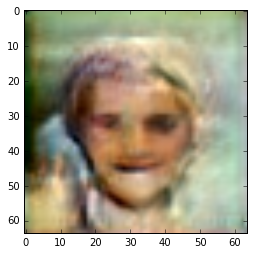

In [11]:
plt.imshow(sample[9])

In [21]:
fd = {disc_real_input:image_batch_c1, gen_noise:in_noise}
#print(sess.run(tf.shape(disc_model_r.outputs[-5]), fd))
sess.run(tf.shape(generator_model.outputs), fd)

array([10, 32, 32,  3], dtype=int32)

In [27]:
sample_num = sample_num + 1
save_output(sample[sample_num],sample_num)
sample_num

15

In [23]:
#Clears everything
sess.close()
tf.reset_default_graph()

In [16]:
saver = tf.train.Saver()


In [17]:
saver.save(sess, 'saves/s', global_step=1)

'saves/s-1'

In [12]:
saver.restore(sess,'saves/s-1')